# Low Rank Adaptation (LoRA)

Why do we need LoRA For fine-tuning?

LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS (Hu et al. 2021)

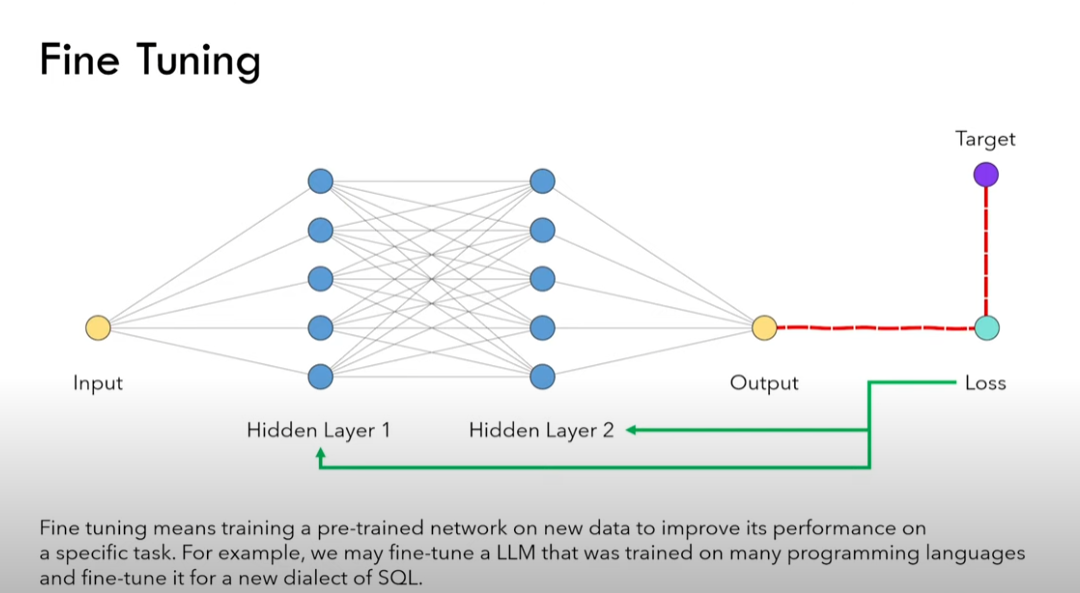

## Problems with Fine-Tuning
1. We must train the full network which is computational expensive
2. Storage requirements for checkpoints are expensive, we need to save the entire model for each checkpoint, We also have to save the optimizer state
3. If we have multiple fine-tuned models, we need to reload all the weights of the model every time we want to switch between them. This can be expensive and slow.


## Introducting LoRA
LoRA provides an elegant solution. Instead of retraining all model parameters, it freezes the pre-trained model weights and introduces trainable rank decomposition matrices into each layer of the Transformer architecture. These matrices significantly reduce the number of trainable parameters for downstream tasks.

Here’s how it works:

* Freezing Pre-Trained Weights: LoRA preserves the pre-trained model’s weights.
* Rank Decomposition Matrices: LoRA injects trainable matrices (B and A) into each layer. These matrices approximate the original model’s weights.
* Reduced Parameters: By using these smaller matrices, LoRA dramatically reduces the number of trainable parameters. For instance, if the original model has W with dimensions (1000 x 5000), LoRA’s B and A matrices are of size (1000 x 1) and (1 x 5000), totaling only 6,000 parameters. During training, we adjust just these 6,000 parameters instead of the original 5,000,000.
* The magic lies in this efficient parameter reduction, allowing LoRA to perform on-par or better than traditional fine-tuning methods while maintaining higher training throughput and no additional inference latency.

LoRA opens up exciting possibilities for LLM development, even for smaller organizations and individual developers. It empowers specialized LLM models to run efficiently on a single machine, making it accessible to the broader data science community

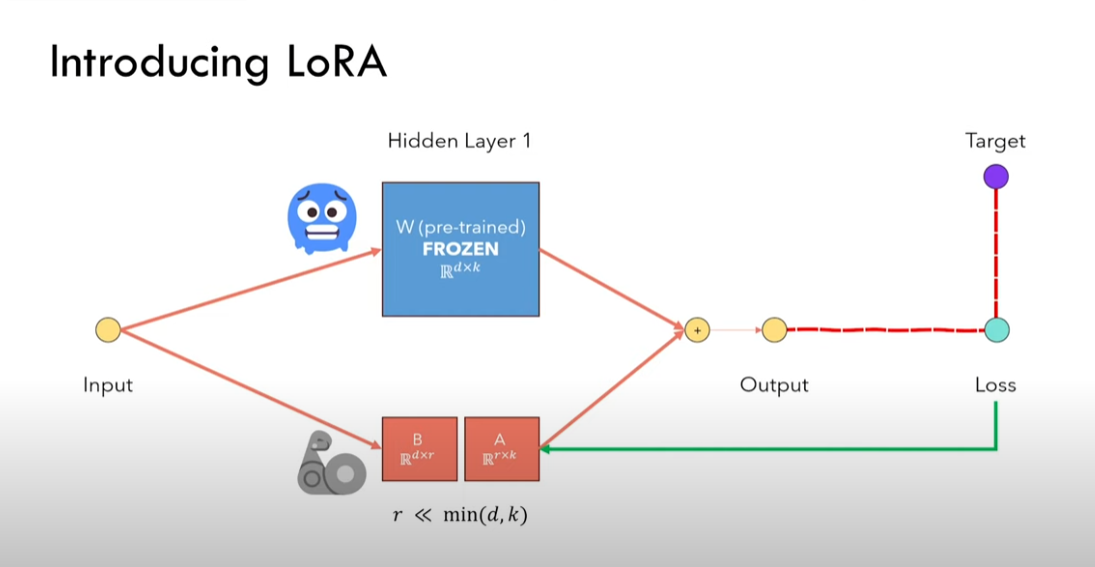

For example, if W is size (1000 x 5000) the number of parameters is 5,000,000. however, during training we can generate B and A that when multiplied are the same size as W, but are size (1000 x 1) and (1 x 5000) which is only 6,000 parameters. This means that during training we're only adjusting 6,000 parameters instead of 5,000,000. The reason this works is that W contains a lot of parameters that are redundant or not useful. By using B and A we can approximate W with a much smaller number of parameters. The loss is only backpropagated through B and A, not W. This means that the original model's weights are preserved and can be used for other tasks without modification.

### Why does LoRA work?
From the paper, When adapating to a specific task, models have a low "intrinsic dimensionality" and can learn efficiently despite a random projection to a smaller subspace. the weights also have a low intrinsic rank structure (linearly independent vectors (columns)). The W matrix is not full rank.



## The benefits of LoRA
1. Reduced computational cost because we only need to train a small number of parameters
2. Reduced storage requirements because we only need to save the small number of parameters
3. Faster training because we only need to train a small number of parameters and backpropagation is faster
4. We can switch between fine-tuned models without reloading the weights of the original model


### References
LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS https://arxiv.org/pdf/2106.09685.pdf

LoRA: Low-Rank Adaptation of Large Language Models - Explained visually + PyTorch code from scratch https://www.youtube.com/watch?v=PXWYUTMt-AU&ab_channel=UmarJamil

An Introduction to Statistical Learning: With Applications in R. Springer Texts in Statistics. New York, NY: Springer US, 2021. https://doi.org/10.1007/978-1-0716-1418-1.


In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.utils.parametrize as parametrize

from tqdm import tqdm

In [2]:
_ = torch.manual_seed(0)

# Singular Value Decomposition (SVD)

In [3]:
# generate a rank-deficient matrix W
d, k = 10, 10

# even though the size of W is d x k (10 x 10), the rank of W is w_rank 2
w_rank = 2
w = torch.randn(d, w_rank) @ torch.randn(w_rank, k)
print(w)

tensor([[-1.0797,  0.5545,  0.8058, -0.7140, -0.1518,  1.0773,  2.3690,  0.8486,
         -1.1825, -3.2632],
        [-0.3303,  0.2283,  0.4145, -0.1924, -0.0215,  0.3276,  0.7926,  0.2233,
         -0.3422, -0.9614],
        [-0.5256,  0.9864,  2.4447, -0.0290,  0.2305,  0.5000,  1.9831, -0.0311,
         -0.3369, -1.1376],
        [ 0.7900, -1.1336, -2.6746,  0.1988, -0.1982, -0.7634, -2.5763, -0.1696,
          0.6227,  1.9294],
        [ 0.1258,  0.1458,  0.5090,  0.1768,  0.1071, -0.1327, -0.0323, -0.2294,
          0.2079,  0.5128],
        [ 0.7697,  0.0050,  0.5725,  0.6870,  0.2783, -0.7818, -1.2253, -0.8533,
          0.9765,  2.5786],
        [ 1.4157, -0.7814, -1.2121,  0.9120,  0.1760, -1.4108, -3.1692, -1.0791,
          1.5325,  4.2447],
        [-0.0119,  0.6050,  1.7245,  0.2584,  0.2528, -0.0086,  0.7198, -0.3620,
          0.1865,  0.3410],
        [ 1.0485, -0.6394, -1.0715,  0.6485,  0.1046, -1.0427, -2.4174, -0.7615,
          1.1147,  3.1054],
        [ 0.9088,  

In [4]:
w_rank_out = torch.linalg.matrix_rank(w)
print(f"Rank of Matrix W: {w_rank_out.item()}")

Rank of Matrix W: 2


### Implement SVD in PyTorch

Single Value Decomposition (SVD) is a matrix factorization method that decomposes a matrix into three matrices, u,s,v. These matrices represent the original matrix in a different form, and their size is determined by the rank of the original matrix.

In [5]:
u, s, v = torch.svd(w)

# for rank-r factorization, keep only the first r singular values (and corresponding columns of U and V)
u_r = u[:, :w_rank]
s_r = torch.diag(s[:w_rank])
v_r = v[:, :w_rank].t() # transpose of V to match the shape of U

# compute c = U_r @ S_r and r = V_r
b = u_r @ s_r
a = v_r

print(f"Reconstructed Matrix B: {b.shape}")
print(b)
print(f"Reconstructed Matrix A: {a.shape}")
print(a)

Reconstructed Matrix B: torch.Size([10, 2])
tensor([[-4.7019,  0.2956],
        [-1.4784, -0.1071],
        [-2.7781, -2.2702],
        [ 3.9371,  2.2360],
        [ 0.4043, -0.7436],
        [ 3.0790, -1.5599],
        [ 6.2024, -0.2048],
        [-0.4607, -2.0147],
        [ 4.6348,  0.0528],
        [ 3.5073, -2.4741]])
Reconstructed Matrix A: torch.Size([2, 10])
tensor([[ 0.2267, -0.1349, -0.2220,  0.1417,  0.0240, -0.2256, -0.5189, -0.1668,
          0.2422,  0.6737],
        [-0.0459, -0.2695, -0.8052, -0.1607, -0.1310,  0.0559, -0.2386,  0.2178,
         -0.1480, -0.3233]])


In [6]:
# Let's apply this to a linear layer
bias = torch.randn(d)
x = torch.randn(d)

y = w @ x + bias
print(f"Output of Linear Layer: {y}")
y_prime = (b @ a) @ x + bias
print(f"Output of Rank-r Linear Layer: {y_prime}")

Output of Linear Layer: tensor([ 7.2684e+00,  2.3162e+00,  7.7151e+00, -1.0446e+01, -8.1639e-03,
        -3.7270e+00, -1.1146e+01,  2.0207e+00, -9.6258e+00, -4.1163e+00])
Output of Rank-r Linear Layer: tensor([ 7.2684e+00,  2.3162e+00,  7.7151e+00, -1.0446e+01, -8.1640e-03,
        -3.7270e+00, -1.1146e+01,  2.0207e+00, -9.6258e+00, -4.1163e+00])


In [7]:
print("Total number of parameters in W: ", w.nelement())
print("Total number of parameters in B and A: ", b.nelement() + a.nelement())
print(f"With {(b.nelement() + a.nelement()) / (w.nelement()) * 100}% of the praameters, we can represent the same linear transformation.")

Total number of parameters in W:  100
Total number of parameters in B and A:  40
With 40.0% of the praameters, we can represent the same linear transformation.


# LoRA in PyTorch

Training a network to classify MNIST digits and then fine-tune the network on a particular digit on which it doesn't perform well

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Create an overly expensive neural network to classify MNIST digits
# Daddy got money, so I don't care about efficiency
class RichBoyNet(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(RichBoyNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = RichBoyNet().to(device)

In [10]:
def train(train_loader, model, epochs=5, total_iterations_limit=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    total_iterations = 0

    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        num_iterations = 0
        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x.view(-1, 28*28))
            loss = criterion(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return

train(train_loader, model, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [00:14<00:00, 405.92it/s, loss=0.243]


In [11]:
# Keep a copy of the original weights (cloning them) so later we can prove that a fine-tuning with LoRA doesn't alter the original weights
original_weights = {}
for name, param in model.named_parameters():
    original_weights[name] = param.clone().detach()

In [12]:
def test():
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')

test()

Testing: 100%|██████████| 1000/1000 [00:01<00:00, 564.74it/s]

Accuracy: 0.951
wrong counts for the digit 0: 9
wrong counts for the digit 1: 15
wrong counts for the digit 2: 91
wrong counts for the digit 3: 15
wrong counts for the digit 4: 69
wrong counts for the digit 5: 108
wrong counts for the digit 6: 29
wrong counts for the digit 7: 66
wrong counts for the digit 8: 42
wrong counts for the digit 9: 48


In [13]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
total_parameters_original = 0
for index, layer in enumerate([model.linear1, model.linear2, model.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


In [14]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        # Section 4.1 of the paper: 
        #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device)) # (r, k)
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device)) # (d, r)
        # B dot A will be (d, r) dot (r, k) = (d, k)
        nn.init.normal_(self.lora_A, mean=0, std=1)
        
        # Section 4.1 of the paper: 
        #   We then scale ∆Wx by α/r , where α is a constant in r. 
        #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately. 
        #   As a result, we simply set α to the first r we try and do not tune it. 
        #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            # LoRA is only applied to the weights, not the biases (as per the paper)
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale
        else:
            return original_weights
        

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.
    
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

def enable_disable_lora(enabled=True):
    for layer in [model.linear1, model.linear2, model.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

In [15]:
# parametrize function works in the following way:
# parametrize.register_parametrization(module, tensorname, parameterization)

parametrize.register_parametrization(
    model.linear1, "weight", linear_layer_parameterization(model.linear1, device)
)
parametrize.register_parametrization(
    model.linear2, "weight", linear_layer_parameterization(model.linear2, device)
)
parametrize.register_parametrization(
    model.linear3, "weight", linear_layer_parameterization(model.linear3, device)
)

In [16]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([model.linear1, model.linear2, model.linear3]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,813,804
Parameters introduced by LoRA: 6,794
Parameters incremment: 0.242%


In [17]:
# Freeze the non-Lora parameters
for name, param in model.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

# Load the MNIST dataset again, by keeping only the digit 9
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
exclude_indices = mnist_trainset.targets == 9
mnist_trainset.data = mnist_trainset.data[exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[exclude_indices]
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Train the network with LoRA only on the digit 9 and only for 100 batches (hoping that it would improve the performance on the digit 9)
train(train_loader, model, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


Epoch 1:  99%|█████████▉| 99/100 [00:00<00:00, 351.26it/s, loss=0.0386]


In [18]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(model.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(model.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(model.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(model.linear1.weight, model.linear1.parametrizations.weight.original + (model.linear1.parametrizations.weight[0].lora_B @ model.linear1.parametrizations.weight[0].lora_A) * model.linear1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(model.linear1.weight, original_weights['linear1.weight'])

In [19]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()


Testing: 100%|██████████| 1000/1000 [00:02<00:00, 458.66it/s]

Accuracy: 0.875
wrong counts for the digit 0: 40
wrong counts for the digit 1: 19
wrong counts for the digit 2: 95
wrong counts for the digit 3: 79
wrong counts for the digit 4: 234
wrong counts for the digit 5: 156
wrong counts for the digit 6: 29
wrong counts for the digit 7: 464
wrong counts for the digit 8: 126
wrong counts for the digit 9: 9


In [20]:
# Test with LoRA disabled
enable_disable_lora(enabled=False)
test()

Testing: 100%|██████████| 1000/1000 [00:02<00:00, 491.18it/s]

Accuracy: 0.951
wrong counts for the digit 0: 9
wrong counts for the digit 1: 15
wrong counts for the digit 2: 91
wrong counts for the digit 3: 15
wrong counts for the digit 4: 69
wrong counts for the digit 5: 108
wrong counts for the digit 6: 29
wrong counts for the digit 7: 66
wrong counts for the digit 8: 42
wrong counts for the digit 9: 48
